In [69]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

* 因为需要全市场回测所以本章无法使用沙盒数据，《量化交易之路》中的原始示例使用的是美股市场，这里的示例改为使用A股市场。
* 本节建议对照阅读abu量化文档第20-23节内容
* 本节的基础是在abu量化文档中第20节内容完成运行后有A股训练集交易和A股测试集交易数据之后

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[abu量化文档教程ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

# 第11章 量化系统-机器学习•ABU

In [70]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, ABuProgress, ABuSymbolPd
from abupy import EMarketTargetType, EDataCacheType, EMarketSourceType, EMarketDataFetchMode, EStoreAbu, AbuUmpMainMul
from abupy import AbuUmpMainDeg, AbuUmpMainJump, AbuUmpMainPrice, AbuUmpMainWave, feature, AbuFeatureDegExtend
from abupy import AbuUmpEdgeDeg, AbuUmpEdgePrice, AbuUmpEdgeWave, AbuUmpEdgeFull, AbuUmpEdgeMul, AbuUmpEegeDegExtend
from abupy import AbuUmpMainDegExtend, ump, Parallel, delayed, AbuMulPidProgress, AbuProgress
,
# 关闭沙盒数据
abupy.env.disable_example_env_ipython()

disable example env


训练集结果：


买入后卖出的交易数量:89418
买入后尚未卖出的交易数量:2012
胜率:46.5220%
平均获利期望:8.4475%
平均亏损期望:-5.6229%
盈亏比:1.3312
策略收益: 61.3978%
基准收益: 111.5646%
策略年化收益: 12.2991%
基准年化收益: 22.3484%
策略买入成交比例:31.7084%
策略资金利用率比例:88.6240%
策略共执行1258个交易日


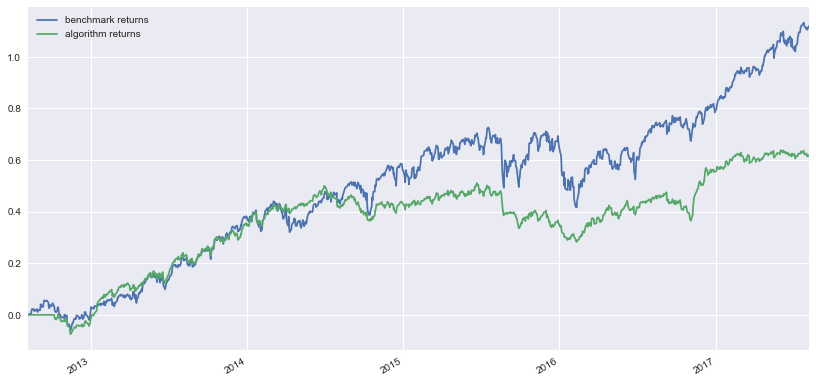

测试集结果：


买入后卖出的交易数量:6321
买入后尚未卖出的交易数量:124
胜率:47.6507%
平均获利期望:15.7211%
平均亏损期望:-7.6456%
盈亏比:2.0477
策略收益: 102.4382%
基准收益: 52.5454%
策略年化收益: 21.2639%
基准年化收益: 10.9073%
策略买入成交比例:26.2064%
策略资金利用率比例:73.9138%
策略共执行1214个交易日


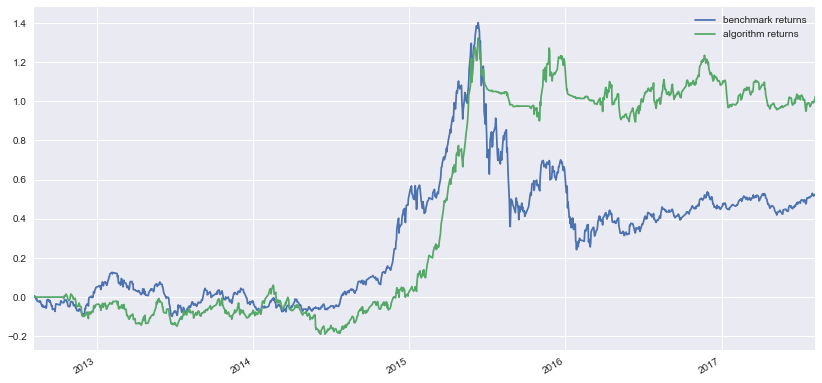

In [13]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL
abu_result_tuple_train = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                             custom_name='train_cn')
abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                             custom_name='test_cn')
ABuProgress.clear_output()
print('训练集结果：')
metrics_train = AbuMetricsBase.show_general(*abu_result_tuple_train, only_show_returns=True)
print('测试集结果：')
metrics_test  = AbuMetricsBase.show_general(*abu_result_tuple_test, only_show_returns=True)

### 11.1 搜索引擎与量化交易

* 本节建议对照abu量化文档第15节内容进行阅读

In [16]:
orders_pd_train = abu_result_tuple_train.orders_pd

In [ ]:
# 选择失败的前20笔交易绘制交易快照
# 这里只是示例，实战中根据需要挑选，rank或者其他方式
plot_simple = orders_pd_train[orders_pd_train.profit_cg < 0][:20]
# save=True保存在本地， 文件保存在~/abu/data/save_png/中
ABuMarketDrawing.plot_candle_from_order(plot_simple, save=True)

## 11.2 主裁

### 11.2.1 角度主裁


请对照阅读ABU量化系统使用文档 ：第15节 中相关内容

In [37]:
from abupy import AbuUmpMainDeg
# 参数为orders_pd
ump_deg = AbuUmpMainDeg(orders_pd_train)
# df即由之前ump_main_make_xy生成的类df，表11-1所示
ump_deg.fiter.df.head()

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21
2012-10-12,0,3.351,18.582,9.453,0.235
2012-10-12,0,1.917,21.440,7.386,2.890
2012-10-12,0,26.084,-24.631,23.113,8.784
2012-10-12,1,2.561,18.982,5.616,3.106
2012-10-12,0,1.397,-14.568,2.074,1.519


耗时操作，快的电脑大概几分钟，具体根据电脑性能，cpu数量，启动多进程进行训练：

pid:21290 gmm fit:100.0%
pid:21288 done!
pid:21287 done!
pid:21291 done!
pid:21290 done!
pid:21289 done!


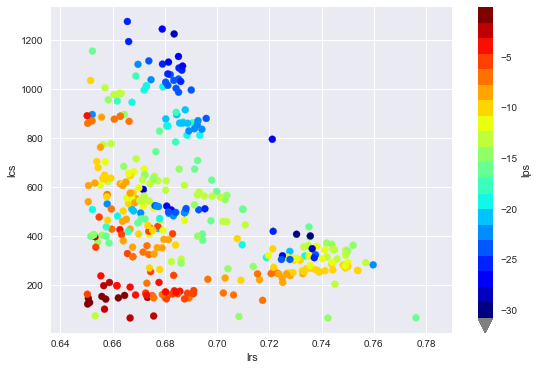

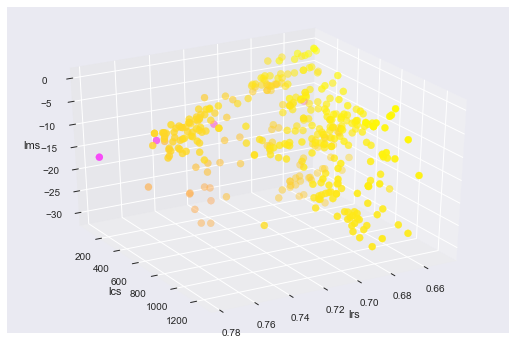

In [19]:
_ = ump_deg.fit(brust_min=False)

In [20]:
ump_deg.cprs

,lcs,lms,lps,lrs
54_32,365,-0.0525,-19.1550,0.7096
54_35,629,-0.0248,-15.6015,0.6979
54_38,947,-0.0195,-18.5037,0.6674
54_47,532,-0.0417,-22.1767,0.6579
54_48,663,-0.0184,-12.2099,0.6682
54_53,796,-0.0335,-26.6577,0.7211
55_1,583,-0.0270,-15.7313,0.6998
55_8,1246,-0.0214,-26.6566,0.6790
55_18,429,-0.0209,-8.9820,0.6667
55_23,1054,-0.0168,-17.7548,0.6689


In [21]:
max_failed_cluster = ump_deg.cprs.loc[ump_deg.cprs.lrs.argmax()]
print('失败概率最大的分类簇{0}, 失败率为{1:.2f}%, 簇交易总数{2}, ' \
      '簇平均交易获利{3:.2f}%'.format(ump_deg.cprs.lrs.argmax(),
                               max_failed_cluster.lrs * 100,
                               max_failed_cluster.lcs,
                               max_failed_cluster.lms * 100))

失败概率最大的分类簇62_47, 失败率为77.61%, 簇交易总数67.0, 簇平均交易获利-25.07%


62


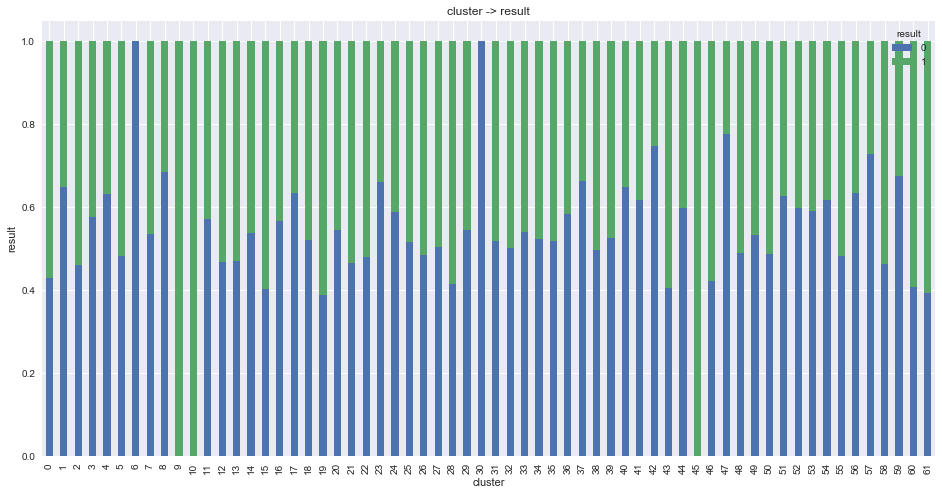

In [22]:
cpt = int(ump_deg.cprs.lrs.argmax().split('_')[0])
print(cpt)
ump_deg.show_parse_rt(ump_deg.rts[cpt])

In [23]:
max_failed_cluster_orders = ump_deg.nts[ump_deg.cprs.lrs.argmax()]
# 表11-3所示
max_failed_cluster_orders

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,ind,cluster
2012-10-22,0,112.561,66.153,36.340,2.480,350,47
2013-02-18,0,41.653,17.688,43.106,32.407,4784,47
2013-09-17,1,52.224,17.227,47.510,17.083,11685,47
2013-10-08,0,43.215,19.480,37.382,22.330,11960,47
2013-10-08,0,43.215,19.480,37.382,22.330,11961,47
2014-07-29,0,46.837,18.532,42.129,18.050,21051,47
2014-10-28,0,46.070,17.231,43.135,8.398,24659,47
2014-10-31,1,43.903,8.968,39.502,14.803,24825,47
2014-11-14,1,51.156,14.066,44.081,30.921,25345,47
2014-12-01,0,45.517,21.550,52.711,1.556,26087,47


由于不是同一份沙盒数据，所以下面结果内容与书中分析内容不符，需要按照实际情况分析:

比如下面的特征即是42日和60日的deg格外大，21和252相对训练集平均值也很大：

分类簇中deg_ang60平均值为45.12
分类簇中deg_ang21平均值为16.93
分类簇中deg_ang42平均值为44.49
分类簇中deg_ang252平均值为20.62


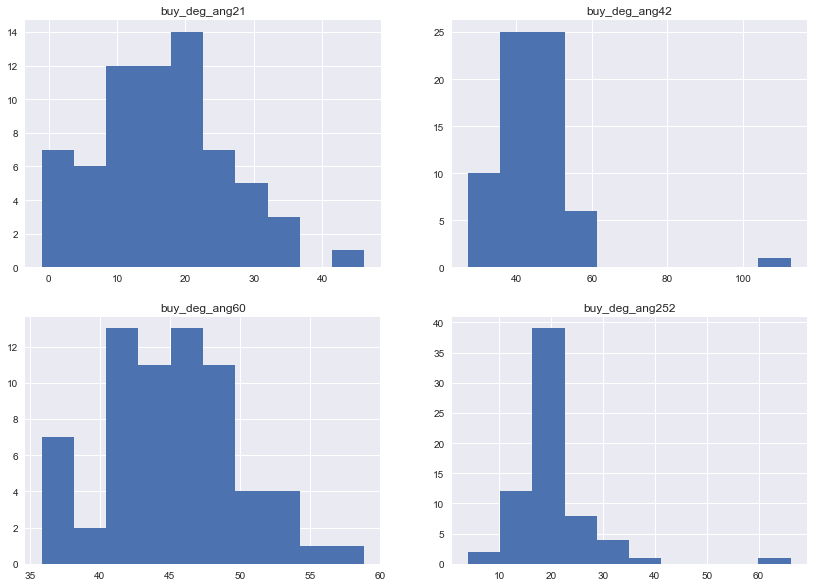

In [25]:
from abupy import ml

ml.show_orders_hist(max_failed_cluster_orders, ['buy_deg_ang21', 'buy_deg_ang42', 'buy_deg_ang60','buy_deg_ang252'])
print('分类簇中deg_ang60平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang60.mean()))

print('分类簇中deg_ang21平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang21.mean()))

print('分类簇中deg_ang42平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang42.mean()))

print('分类簇中deg_ang252平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_deg_ang252.mean()))

训练数据集中deg_ang60平均值为2.95
训练数据集中deg_ang21平均值为5.08
训练数据集中deg_ang42平均值为4.94
训练数据集中deg_ang252平均值为4.92


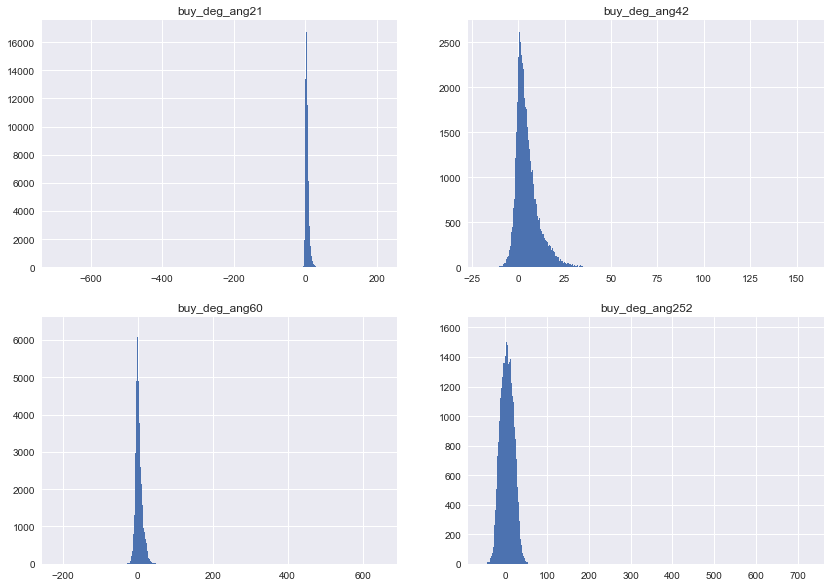

In [26]:
ml.show_orders_hist(orders_pd_train, ['buy_deg_ang21', 'buy_deg_ang42', 'buy_deg_ang60', 'buy_deg_ang252'])
print('训练数据集中deg_ang60平均值为{0:.2f}'.format(
    orders_pd_train.buy_deg_ang60.mean()))

print('训练数据集中deg_ang21平均值为{0:.2f}'.format(
    orders_pd_train.buy_deg_ang21.mean()))

print('训练数据集中deg_ang42平均值为{0:.2f}'.format(
    orders_pd_train.buy_deg_ang42.mean()))

print('训练数据集中deg_ang252平均值为{0:.2f}'.format(
    orders_pd_train.buy_deg_ang252.mean()))

In [31]:
progress = AbuProgress(len(max_failed_cluster_orders), 0, label='plot snap')
for ind in np.arange(0, len(max_failed_cluster_orders)):
    progress.show(ind)
    order_ind = int(max_failed_cluster_orders.iloc[ind].ind)
    # 交易快照文件保存在~/abu/data/save_png/中
    ABuMarketDrawing.plot_candle_from_order(ump_deg.fiter.order_has_ret.iloc[order_ind], save=True)

plot snap::98.51%

交易快照文件保存在~/abu/data/save_png/中, 下面打开对应目录：save_png

In [32]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

### 11.2.2 使用全局最优对分类簇集合进行筛选

In [33]:
brust_min = ump_deg.brust_min()
brust_min

array([-0.205 , -0.0017,  0.65  ])

In [34]:
llps = ump_deg.cprs[(ump_deg.cprs['lps'] <= brust_min[0]) & (ump_deg.cprs['lms'] <= brust_min[1] )& (ump_deg.cprs['lrs'] >=brust_min[2])]
llps

,lcs,lms,lps,lrs
54_32,365,-0.0525,-19.1550,0.7096
54_35,629,-0.0248,-15.6015,0.6979
54_38,947,-0.0195,-18.5037,0.6674
54_47,532,-0.0417,-22.1767,0.6579
54_48,663,-0.0184,-12.2099,0.6682
54_53,796,-0.0335,-26.6577,0.7211
55_1,583,-0.0270,-15.7313,0.6998
55_8,1246,-0.0214,-26.6566,0.6790
55_18,429,-0.0209,-8.9820,0.6667
55_23,1054,-0.0168,-17.7548,0.6689


拦截的交易中正确拦截比例:0.651
训练集中拦截生效后可提升比例:0.053
训练集中拦截生效数量9720， 训练集中拦截生效占总训练集比例17.601%


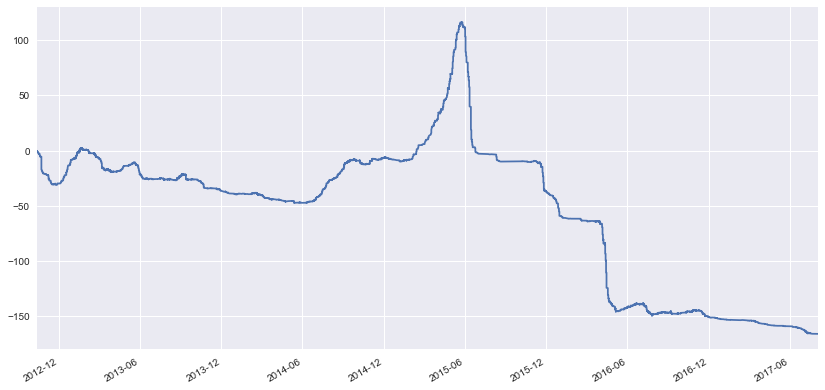

In [35]:
ump_deg.choose_cprs_component(llps)

In [36]:
ump_deg.dump_clf(llps)

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_main_hs_deg_main


### 11.2.3 跳空主裁

请对照阅读ABU量化系统使用文档 ：第16节 UMP主裁交易决策 中相关内容

In [ ]:
from abupy import AbuUmpMainJump
# 耗时操作，大概需要10几分钟，具体根据电脑性能，cpu情况
ump_jump = AbuUmpMainJump.ump_main_clf_dump(orders_pd_train, save_order=False)

In [39]:
ump_jump.fiter.df.head()

,result,buy_diff_up_days,buy_jump_down_power,buy_diff_down_days,buy_jump_up_power
2012-10-12,0,244,-1.269,155,2.17
2012-10-12,0,0,-1.088,171,0.00
2012-10-12,0,0,-1.159,170,0.00
2012-10-12,1,0,-1.327,162,0.00
2012-10-12,0,0,0.000,0,1.22


下面这个的这个拦截特征比较明显，两天前才发生向上跳空的交易：

In [40]:
print('失败概率最大的分类簇{0}'.format(ump_jump.cprs.lrs.argmax()))
# 拿出跳空失败概率最大的分类簇
max_failed_cluster_orders = ump_jump.nts[ump_jump.cprs.lrs.argmax()]
# 显示失败概率最大的分类簇，表11-6所示
max_failed_cluster_orders

失败概率最大的分类簇54_39


,result,buy_diff_up_days,buy_jump_down_power,buy_diff_down_days,buy_jump_up_power,ind,cluster
2012-11-02,0,2,-1.831,191,1.156,562,39
2013-02-21,0,2,-1.037,21,1.274,4931,39
2013-04-08,0,2,-1.007,154,1.319,5785,39
2013-05-17,1,2,-1.689,73,1.222,6807,39
2013-05-23,0,2,-1.094,79,1.097,7443,39
2013-05-23,0,2,-1.094,79,1.097,7449,39
2013-06-03,0,2,-1.741,53,1.096,8088,39
2013-06-07,0,2,-1.238,59,1.356,8269,39
2013-06-13,0,2,-1.255,256,1.747,8289,39
2013-10-17,0,2,-1.402,300,2.142,12358,39


分类簇中jump_up_power平均值为1.99， 向上跳空平均天数2.00
分类簇中jump_down_power平均值为-1.57, 向下跳空平均天数157.34
训练数据集中jump_up_power平均值为1.26，向上跳空平均天数87.13
训练数据集中jump_down_power平均值为-0.79, 向下跳空平均天数83.27


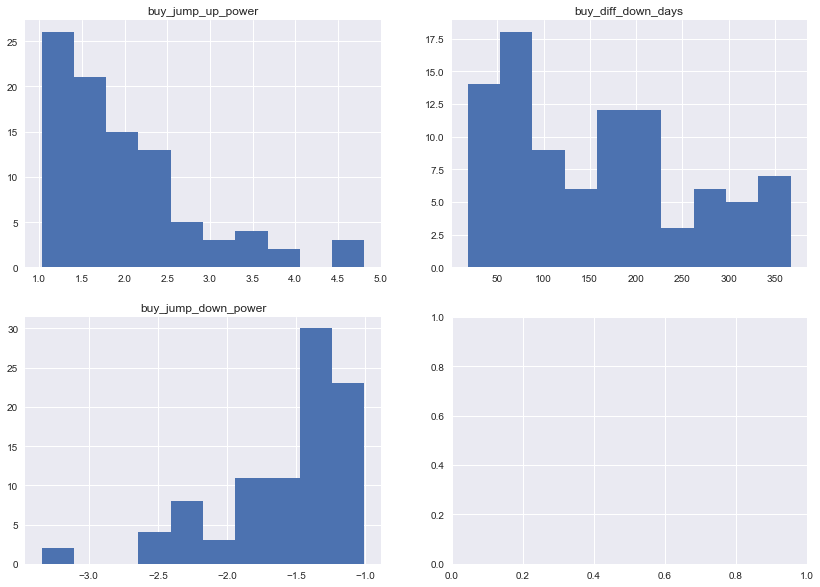

In [49]:
ml.show_orders_hist(max_failed_cluster_orders, feature_columns=['buy_diff_up_days', 'buy_jump_up_power', 
                                                                'buy_diff_down_days', 'buy_jump_down_power'])

print('分类簇中jump_up_power平均值为{0:.2f}， 向上跳空平均天数{1:.2f}'.format(
    max_failed_cluster_orders.buy_jump_up_power.mean(), max_failed_cluster_orders.buy_diff_up_days.mean()))

print('分类簇中jump_down_power平均值为{0:.2f}, 向下跳空平均天数{1:.2f}'.format(
    max_failed_cluster_orders.buy_jump_down_power.mean(), max_failed_cluster_orders.buy_diff_down_days.mean()))

print('训练数据集中jump_up_power平均值为{0:.2f}，向上跳空平均天数{1:.2f}'.format(
    orders_pd_train.buy_jump_up_power.mean(), orders_pd_train.buy_diff_up_days.mean()))

print('训练数据集中jump_down_power平均值为{0:.2f}, 向下跳空平均天数{1:.2f}'.format(
    orders_pd_train.buy_jump_down_power.mean(), orders_pd_train.buy_diff_down_days.mean()))

### 11.2.4 价格主裁

请对照阅读ABU量化系统使用文档 ：第16节 UMP主裁交易决策 中相关内容

In [50]:
from abupy import AbuUmpMainPrice
ump_price = AbuUmpMainPrice.ump_main_clf_dump(orders_pd_train, save_order=False)

pid:21557 gmm fit:100.0%
pid:21555 done!
pid:21556 done!
pid:21557 done!
please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_main_hs_price_main


In [51]:
ump_price.fiter.df.head()

,result,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252
2012-10-12,0,1.000,1.000,1.000,1.000
2012-10-12,0,1.000,1.000,1.000,1.000
2012-10-12,0,0.996,0.994,0.992,0.788
2012-10-12,1,1.000,1.000,1.000,1.000
2012-10-12,0,0.533,0.711,1.000,0.393


In [52]:
print('失败概率最大的分类簇{0}'.format(ump_price.cprs.lrs.argmax()))

# 拿出价格失败概率最大的分类簇
max_failed_cluster_orders = ump_price.nts[ump_price.cprs.lrs.argmax()]
# 表11-8所示
max_failed_cluster_orders

失败概率最大的分类簇93_66


,result,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,ind,cluster
2013-01-28,1,0.562,0.717,1.0,0.351,4481,66
2013-02-18,0,0.525,0.689,1.0,0.312,4809,66
2013-09-04,1,0.521,0.667,1.0,0.383,10839,66
2013-09-09,0,0.512,0.678,1.0,0.375,11065,66
2013-09-12,1,0.504,0.667,1.0,0.296,11478,66
2013-09-12,0,0.525,0.689,1.0,0.371,11500,66
2013-09-12,0,0.529,0.667,1.0,0.387,11513,66
2013-09-12,0,0.529,0.667,1.0,0.387,11515,66
2013-09-13,0,0.571,0.722,1.0,0.429,11530,66
2013-09-13,0,0.575,0.733,1.0,0.397,11544,66


### 11.2.5 波动主裁

请对照阅读ABU量化系统使用文档 ：第16节 UMP主裁交易决策 中相关内容

In [53]:
from abupy import AbuUmpMainWave
ump_wave = AbuUmpMainWave.ump_main_clf_dump(orders_pd_train, save_order=False)

pid:21599 gmm fit:100.0%
pid:21596 done!
pid:21597 done!
pid:21598 done!
pid:21599 done!


AbuUmpMainWave: cprs shape < 50!


please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_main_hs_wave_main


In [54]:
ump_wave.fiter.df.head()

,result,buy_wave_score1,buy_wave_score2,buy_wave_score3
2012-10-12,0,0.832,0.779,0.812
2012-10-12,0,0.027,-0.237,-0.281
2012-10-12,0,1.861,1.779,1.664
2012-10-12,1,-0.150,-0.166,-0.088
2012-10-12,0,0.121,-0.053,-0.115


In [55]:
print('失败概率最大的分类簇{0}'.format(ump_wave.cprs.lrs.argmax()))
# 拿出波动特征失败概率最大的分类簇
max_failed_cluster_orders = ump_wave.nts[ump_wave.cprs.lrs.argmax()]
# 表11-10所示
max_failed_cluster_orders

失败概率最大的分类簇78_7


,result,buy_wave_score1,buy_wave_score2,buy_wave_score3,ind,cluster
2012-10-19,0,2.784,2.730,2.571,303,7
2013-03-22,0,2.326,2.219,2.147,5512,7
2013-03-22,0,2.326,2.219,2.147,5514,7
2013-03-25,0,2.722,2.678,2.542,5569,7
2013-05-13,1,2.336,2.351,2.323,6503,7
2013-07-18,1,2.716,2.640,2.482,8567,7
2013-08-20,0,2.382,2.272,2.186,9748,7
2013-08-28,1,2.321,2.228,2.136,10336,7
2013-09-02,1,2.456,2.340,2.238,10636,7
2013-09-10,0,2.488,2.525,2.504,11187,7


分类簇中wave_score1平均值为2.50
分类簇中wave_score3平均值为2.38
训练数据集中wave_score1平均值为0.51
训练数据集中wave_score3平均值为0.51


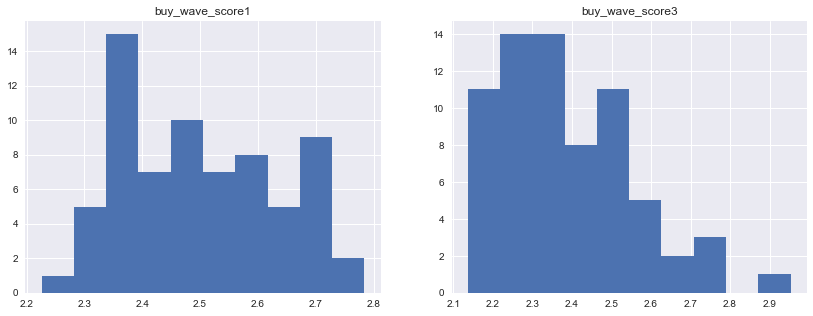

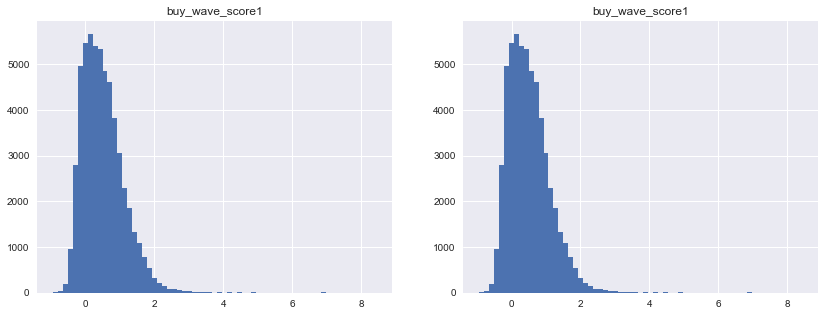

In [60]:
ml.show_orders_hist(max_failed_cluster_orders, feature_columns=['buy_wave_score1', 'buy_wave_score3'])

print('分类簇中wave_score1平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_wave_score1.mean()))

print('分类簇中wave_score3平均值为{0:.2f}'.format(
    max_failed_cluster_orders.buy_wave_score3.mean()))

ml.show_orders_hist(orders_pd_train, feature_columns=['buy_wave_score1', 'buy_wave_score1'])

print('训练数据集中wave_score1平均值为{0:.2f}'.format(
    orders_pd_train.buy_wave_score1.mean()))

print('训练数据集中wave_score3平均值为{0:.2f}'.format(
    orders_pd_train.buy_wave_score1.mean()))

### 11.2.6 验证主裁是否称职


请对照阅读ABU量化系统使用文档 ：第21节 A股UMP决策 中相关内容

In [61]:
# 选取有交易结果的数据order_has_result
order_has_result = abu_result_tuple_test.orders_pd[abu_result_tuple_test.orders_pd.result != 0]

In [62]:
ump_wave.best_hit_cnt_info(ump_wave.llps)

mean_hit_failed = 4.0


In [63]:
from abupy import AbuUmpMainDeg, AbuUmpMainJump, AbuUmpMainPrice, AbuUmpMainWave
ump_deg = AbuUmpMainDeg(predict=True)
ump_jump = AbuUmpMainJump(predict=True)
ump_price = AbuUmpMainPrice(predict=True)
ump_wave = AbuUmpMainWave(predict=True)

In [65]:
def apply_ml_features_ump(order, predicter, progress, need_hit_cnt):
    if not isinstance(order.ml_features, dict):
        import ast
        # 低版本pandas dict对象取出来会成为str
        ml_features = ast.literal_eval(order.ml_features)
    else:
        ml_features = order.ml_features
    progress.show()
    # 将交易单中的买入时刻特征传递给ump主裁决策器，让每一个主裁来决策是否进行拦截
    return predicter.predict_kwargs(need_hit_cnt=need_hit_cnt, **ml_features)

def pararllel_func(ump, ump_name):
    with AbuMulPidProgress(len(order_has_result), '{} complete'.format(ump_name)) as progress:
        # 启动多进程进度条，对order_has_result进行apply
        ump_result = order_has_result.apply(apply_ml_features_ump, axis=1, args=(ump, progress, 2,))
    return ump_name, ump_result

# 并行处理4个主裁，每一个主裁启动一个进程进行拦截决策
parallel = Parallel(
    n_jobs=4, verbose=0, pre_dispatch='2*n_jobs')
out = parallel(delayed(pararllel_func)(ump, ump_name)
                              for ump, ump_name in zip([ump_deg, ump_jump, ump_price, ump_wave], 
                                                       ['ump_deg', 'ump_jump', 'ump_price', 'ump_wave']))

# 将每一个进程中的裁判的拦截决策进行汇总
for sub_out in out:
    order_has_result[sub_out[0]] = sub_out[1]

pid:21667 ump_deg complete:99.67%
pid:21667 done!


In [66]:
block_pd = order_has_result.filter(regex='^ump_*')
# 把所有主裁的决策进行相加
block_pd['sum_bk'] = block_pd.sum(axis=1)
block_pd['result'] = order_has_result['result']
# 有投票1的即会进行拦截
block_pd = block_pd[block_pd.sum_bk > 0]
print('四个裁判整体拦截正确率{:.2f}%'.format(block_pd[block_pd.result == -1].result.count() / block_pd.result.count() * 100))
block_pd.tail()

四个裁判整体拦截正确率63.33%


,ump_deg,ump_jump,ump_price,ump_wave,sum_bk,result
2017-07-20,1,0,1,0,2,-1
2017-07-21,0,0,1,0,1,-1
2017-07-21,0,0,1,0,1,-1
2017-08-01,0,0,1,0,1,-1
2017-08-03,0,0,1,0,1,-1


In [68]:
print('角度裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_deg')))
print('角度扩展裁判拦拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_jump')))
print('单混裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_wave')))
print('价格裁判拦截正确率{:.2f}%, 拦截交易数量{}'.format(*sub_ump_show('ump_price')))

角度裁判拦截正确率65.09%, 拦截交易数量974
角度扩展裁判拦拦截正确率66.67%, 拦截交易数量3
单混裁判拦截正确率67.06%, 拦截交易数量85
价格裁判拦截正确率64.57%, 拦截交易数量796


### 11.2.7 在abu系统中开启主裁拦截模式

请对照阅读ABU量化系统使用文档 ：第21节 A股UMP决策 中相关内容

## 11.3 边裁

### 11.3.1 角度边裁

请对照阅读ABU量化系统使用文档 ：第17节 UMP边裁交易决策，第21节 A股UMP决策 中相关内容

### 11.3.2 价格边裁

请对照阅读ABU量化系统使用文档 ：第17节 UMP边裁交易决策，第21节 A股UMP决策 中相关内容

### 11.3.3 波动边裁

请对照阅读ABU量化系统使用文档 ：第17节 UMP边裁交易决策，第21节 A股UMP决策 中相关内容

### 11.3.4 综合边裁

请对照阅读ABU量化系统使用文档 ：第17节 UMP边裁交易决策，第21节 A股UMP决策 中相关内容

### 11.3.5 验证边裁是否称职

请对照阅读ABU量化系统使用文档 ：第21节 A股UMP决策 中相关内容

### 11.3.6 在abu系统中开启边裁拦截模式

请对照阅读ABU量化系统使用文档 ：第21节 A股UMP决策 中相关内容